# Bank marketing classification project

In [1]:
#enable auto complete
%config IPCompleter.greedy=True

In [2]:
#import libraries
import os, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn models
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#pipelines dimension reduction
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#sklearn classification accuracy metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, f1_score


In [3]:
# import dataset and create copy
df = pd.read_csv('bank-full.csv', sep=';', header=0)
df_copy = df.copy()
print(df_copy.head(1))

   age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome   y  
0    5   may       261         1     -1         0  unknown  no  


In [4]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# find range for numeric var copy_bank.describe()
df_copy.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
#conform unique value count
df_copy.select_dtypes(include='object').apply(lambda i: print(i.unique()))

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
['married' 'single' 'divorced']
['tertiary' 'secondary' 'unknown' 'primary']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['unknown' 'cellular' 'telephone']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
['unknown' 'failure' 'other' 'success']
['no' 'yes']


job          None
marital      None
education    None
default      None
housing      None
loan         None
contact      None
month        None
poutcome     None
y            None
dtype: object

# data dictionary

### Dependent variable (categorical data type)
* **y:** has the client subscribed a term deposit? (yes, no)

## Object ariables 

* **job :** (admin, technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student)
* **marital:** (married, single, divorced)
* **education:** (primary, secondary, tertiary, unknown)
* **default:** has credit in default? (yes, no)
* **housing:** has housing loan? (yes, no)
* **loan:** has personal loan? (yes, no)

### Related with the last contact of the current campaign:
* **contact:** contact communication type (unknown, cellular, telephone)
* **month:** last contact month of year (jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec)
* **poutcome:** outcome of the previous marketing campaign (unknown, other, failure, success)

## Numerical Variables
* **age**: [18,95]
* **balance**: average yearly balance, in euros [-8,019, 102,127]
* **day:** last contact day of the month [1, 31]
* **campaign**: number of contacts performed during this campaign and for this client (includes last contact) [1, 63]
* **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; "-1" means client was not previously contacted)[-1, 871]
* **previous**: number of contacts performed before this campaign and for this client [0, 275]

## Removed for prediction purposes
* **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. [0, 4,918]






In [7]:
#remove duration
df_copy.drop(['duration'], axis=1, inplace=True)

# group into smaller categories
df_copy.job = df_copy.job.replace(['management', 'admin.'],'white collar')
df_copy.job = df_copy.job.replace(['services','housemaid'],'pink collar')
df_copy.job = df_copy.job.replace(['student','unknown', 'retired','unemployed'],'other')

print(df_copy.job.value_counts())

white collar     14629
blue-collar       9732
technician        7597
pink collar       5394
other             4793
self-employed     1579
entrepreneur      1487
Name: job, dtype: int64


In [8]:
# map data for simple object variables

# dictionary for data cleanup
dict_clean_up = {
    'month': {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12},
    'default':{'yes':1, 'no':0},
    'housing':{'yes':1, 'no':0},
    'loan':{'yes':1, 'no':0},
    'y':{'yes':1, 'no':0}
}
              
df_copy.replace(dict_clean_up, inplace=True)
df_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null int64
balance      45211 non-null int64
housing      45211 non-null int64
loan         45211 non-null int64
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null int64
dtypes: int64(11), object(5)
memory usage: 5.5+ MB


In [9]:
# dummify more complex data objects 
df_dummies = pd.get_dummies(data=df_copy, columns=['job', 'marital', 'education', 'contact', 'poutcome' ,], prefix = ['job', 'marital', 'education', 'contact', 'poutcome'])


In [10]:
#check data types
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 32 columns):
age                    45211 non-null int64
default                45211 non-null int64
balance                45211 non-null int64
housing                45211 non-null int64
loan                   45211 non-null int64
day                    45211 non-null int64
month                  45211 non-null int64
campaign               45211 non-null int64
pdays                  45211 non-null int64
previous               45211 non-null int64
y                      45211 non-null int64
job_blue-collar        45211 non-null uint8
job_entrepreneur       45211 non-null uint8
job_other              45211 non-null uint8
job_pink collar        45211 non-null uint8
job_self-employed      45211 non-null uint8
job_technician         45211 non-null uint8
job_white collar       45211 non-null uint8
marital_divorced       45211 non-null uint8
marital_married        45211 non-null uint8
marital_sin

# Correlations

In [11]:
# make correlation, covariance matrices and export
df_corr = df_dummies.corr()
df_cov = df_dummies.cov()
df_corr.to_csv('corr.csv')
df_cov.to_csv('cov.csv')

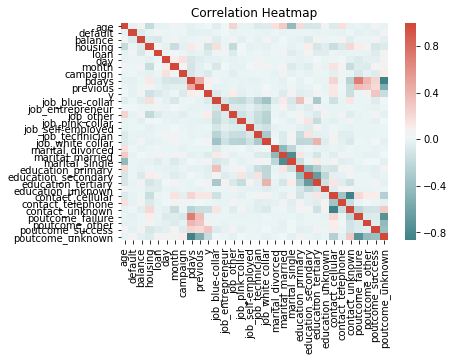

In [12]:
#### plot correlation matrix
#assign color map
cmap = sns.diverging_palette(200,15, as_cmap=True)

# set up sns heatmap
sns.heatmap(df_corr, xticklabels=df_corr.columns.values, 
yticklabels=df_corr.columns.values, cmap=cmap)

#plot
plt.title('Correlation Heatmap')
plt.plot()
plt.show()


In [13]:
# print y - correlation


In [14]:
s_y_corr = pd.Series(df_corr.y).sort_values(ascending = False)
print(s_y_corr.head(5))
print(s_y_corr.tail(5))

y                   1.000000
poutcome_success    0.306788
contact_cellular    0.135873
pdays               0.103621
job_other           0.102895
Name: y, dtype: float64
job_blue-collar    -0.072083
campaign           -0.073172
housing            -0.139173
contact_unknown    -0.150935
poutcome_unknown   -0.167051
Name: y, dtype: float64


### No strong correlation between any variables, so no columns were removed to avoid colinearity.

* **poutcome_success & contact cellular** had the highest correlations with y

# Visual Exploratory Data Analysis(EDA)

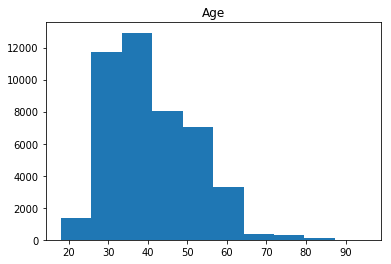

In [15]:
#age histogram 
plt.hist(df_dummies.age)
plt.title('Age')
plt.show()

new term deposit success rate: 13.25%

y
0    39922
1     5289
Name: y, dtype: int64


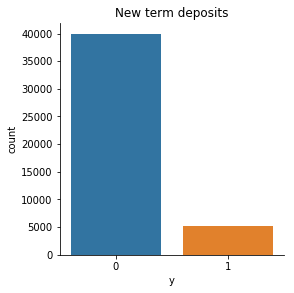

In [16]:
#dependent variable EDA 
print("new term deposit success rate: " + str(round((5289/39922*100),2)) +'%')
print()
print(df_dummies.groupby('y')['y'].count())

sns.factorplot('y', data = df_dummies, kind='count')
plt.title('New term deposits')
plt.show()

poutcome success rate 3.46%

poutcome_success
0    43700
1     1511
Name: poutcome_success, dtype: int64


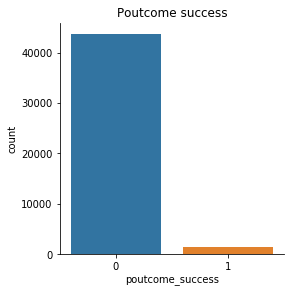

In [17]:
#
print('poutcome success rate ' + str(round((1511/43700*100),2)) + '%')
print()
print(df_dummies.groupby('poutcome_success')['poutcome_success'].count())

sns.factorplot('poutcome_success', data = df_dummies, kind='count')
plt.title('Poutcome success')
plt.show()


Success rate of term deposits based on prior marketing success 22.69%

success rate of prior marketing success 64.73%

y  poutcome_success
0  0                   39389
   1                     533
1  0                    4311
   1                     978
dtype: int64


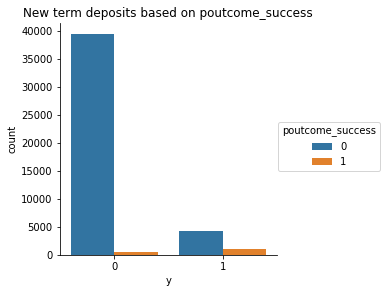

In [18]:
# look at y based on poutcome_success
print('Success rate of term deposits based on prior marketing success ' + str(round((978/4311*100),2)) + '%')
print()
print('success rate of prior marketing success ' + str(round((978/1511*100),2)) + '%')
print()
print(df_dummies.groupby(['y','poutcome_success']).size())


sns.factorplot('y', data = df_dummies, kind='count', hue = 'poutcome_success')
plt.title('New term deposits based on poutcome_success')
plt.show()


/Users/lynchno/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


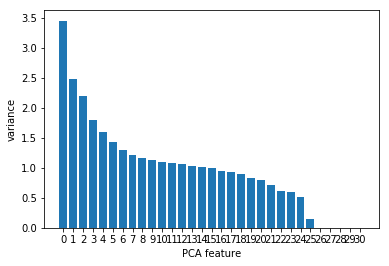

In [19]:
#assign features to X
X = df_dummies.drop('y', axis=1).values

# PCA reduction, which requires scaled features
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

# from graph, pick PCA(n_components = 7)

In [20]:
# separate dataframes into x and y numpy arrays
y = df_dummies.y.values

#train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)


In [21]:
#standardized KNN
knn_clf = make_pipeline(StandardScaler(), PCA(n_components=7), KNeighborsClassifier())
#print(sorted(knn_clf.get_params().keys()))

knn_grid = {'kneighborsclassifier__n_neighbors':np.arange(2,22,2)}
knn_cv = GridSearchCV(knn_clf, param_grid = knn_grid, cv = 5)
%timeit knn_cv.fit(X_train, y_train)
print("Tuned knn parameters: {}".format(knn_cv.best_params_))
print("Best avg cross validation score is {}".format(knn_cv.best_score_))

57.6 s ± 5.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tuned knn parameters: {'kneighborsclassifier__n_neighbors': 18}
Best avg cross validation score is 0.8890732138907321


In [22]:
#RF model


rf_clf = make_pipeline(StandardScaler(), PCA(n_components=7),RandomForestClassifier(random_state = 123))
#print(sorted(rf_clf.get_params().keys()))

param_grid = {'randomforestclassifier__n_estimators': np.arange(5, 30, 5),
             'randomforestclassifier__criterion': ["gini", "entropy"]}
rf_cv = GridSearchCV(rf_clf, param_grid, cv = 5)
%timeit rf_cv.fit(X_train, y_train)

print("Tuned rf parameters: {}".format(rf_cv.best_params_))
print("Best avg cross validation score is {}".format(rf_cv.best_score_))


1min 28s ± 6.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tuned rf parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 20}
Best avg cross validation score is 0.8856171201061712


In [23]:
svc_clf = make_pipeline(StandardScaler(), PCA(n_components=7), SVC(random_state = 123))
#print(svc_clf.get_params().keys())

param_grid = {'svc__kernel':['linear', 'rbf'],'svc__C':np.arange(0.5, 2, 0.5)}

svc_cv = GridSearchCV(svc_clf, param_grid, cv = 5)
%timeit svc_cv.fit(X_train, y_train)

print("Tuned svc parameters: {}".format(svc_cv.best_params_))
print("Best avg cross validation score is {}".format(svc_cv.best_score_))


11min 39s ± 11.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tuned svc parameters: {'svc__C': 1.0, 'svc__kernel': 'rbf'}
Best avg cross validation score is 0.8896261888962619


In [29]:
# cross validation scores
rf = make_pipeline(StandardScaler(), PCA(n_components=7), RandomForestClassifier(criterion='gini', n_estimators=20,random_state = 123))
svc = make_pipeline(StandardScaler(), PCA(n_components=7), SVC(C=1, kernel = 'rbf', random_state=123))
knn = make_pipeline(StandardScaler(), PCA(n_components=7), KNeighborsClassifier(n_neighbors = 18))
l_models = [knn, rf, svc]


for c,value in enumerate(l_models):
    value.fit(X_train,y_train)
    print(str(c))
    print('cross val')
    print(cross_val_score(value, X_train, y_train))
    print('mean cv score: ' + str(np.mean(cross_val_score(value, X_train, y_train))))


0
cross val
[0.88745127 0.88951559 0.89025301]
mean cv score: 0.8891838794756287
1
cross val
[0.88463133 0.88387525 0.88502696]
mean cv score: 0.8855065475159272
2
cross val
[0.88911006 0.88852024 0.89025301]
mean cv score: 0.8890179456965299


# graph training vs testing accuracy to look for signs of overfit

## KNN

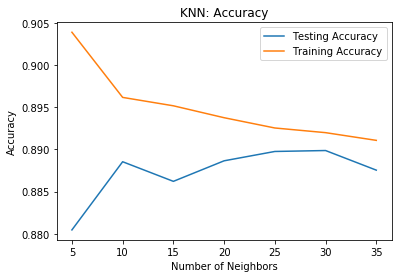

In [25]:
neighbors = np.arange(5,40, 5)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

# test different K values

for counter, values in enumerate(neighbors):
    knn = make_pipeline(StandardScaler(),PCA(n_components=7),KNeighborsClassifier(n_neighbors=values))
    knn.fit(X_train, y_train)
    train_acc[counter] = knn.score(X_train, y_train)
    test_acc[counter] = knn.score(X_test, y_test)

### generate accuracy plot
plt.title('KNN: Accuracy')
plt.plot(neighbors, test_acc, label = 'Testing Accuracy')
plt.plot(neighbors, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

## RF

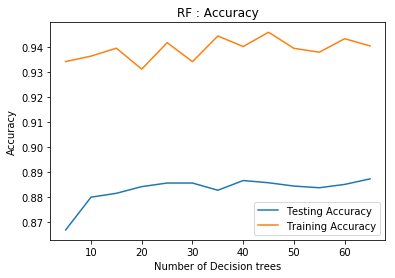

In [26]:
estimators = np.arange(5,70, 5)
train_acc = np.empty(len(estimators))
test_acc = np.empty(len(estimators))

for counter, values in enumerate(estimators):
    rf = make_pipeline(StandardScaler(),PCA(n_components= 7),RandomForestClassifier(n_estimators=values, criterion='gini', random_state=123))
    rf.fit(X_train, y_train)
    train_acc[counter] = rf.score(X_train, y_train)
    test_acc[counter] = rf.score(X_test, y_test)

plt.title('RF : Accuracy')
plt.plot(estimators, test_acc, label = 'Testing Accuracy')
plt.plot(estimators, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Decision trees')
plt.ylabel('Accuracy')
plt.show()

In [36]:
print(X_train.shape)
print(y_train.shape)

(36168, 31)
(36168,)


## SVC

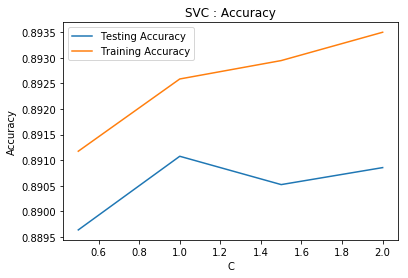

In [37]:
estimators = np.arange(0.5,2.5, .5)
train_acc = np.empty(len(estimators))
test_acc = np.empty(len(estimators))

for counter, values in enumerate(estimators):
    svc = make_pipeline(StandardScaler(),PCA(n_components=7),SVC(C=values, kernel ='rbf', random_state = 123))
    svc.fit(X_train, y_train)
    train_acc[counter] = svc.score(X_train, y_train)
    test_acc[counter] = svc.score(X_test, y_test)

plt.title('SVC : Accuracy')
plt.plot(estimators, test_acc, label = 'Testing Accuracy')
plt.plot(estimators, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [38]:
knn = make_pipeline(StandardScaler(), PCA(n_components=7), KNeighborsClassifier(n_neighbors = 18))
rf = make_pipeline(StandardScaler(), PCA(n_components=7), RandomForestClassifier(criterion='gini', n_estimators=20,random_state=123))
svc = make_pipeline(StandardScaler(), PCA(n_components=7), SVC(C=1.0, kernel = 'rbf', random_state=123))
l_models = [knn, rf, svc]


for c,value in enumerate(l_models):
    value.fit(X_train, y_train)
    y_pred = value.predict(X_test)
    F1 = f1_score(y_test, y_pred)
    print(str(c))
    print('F1 score: %.3f' % F1)
    print()
    print('confusion matrix')
    print(confusion_matrix(y_test, y_pred))
    print()
    print('classification report')
    print(classification_report(y_test, y_pred))
    print()


0
F1 score: 0.232

confusion matrix
[[7890   96]
 [ 906  151]]

classification report
             precision    recall  f1-score   support

          0       0.90      0.99      0.94      7986
          1       0.61      0.14      0.23      1057

avg / total       0.86      0.89      0.86      9043


1
F1 score: 0.233

confusion matrix
[[7846  140]
 [ 899  158]]

classification report
             precision    recall  f1-score   support

          0       0.90      0.98      0.94      7986
          1       0.53      0.15      0.23      1057

avg / total       0.85      0.89      0.86      9043


2
F1 score: 0.201

confusion matrix
[[7927   59]
 [ 932  125]]

classification report
             precision    recall  f1-score   support

          0       0.89      0.99      0.94      7986
          1       0.68      0.12      0.20      1057

avg / total       0.87      0.89      0.85      9043


